=== Peng-Robinson 상태방정식 계산 결과 ===
온도: 200.0°C (473.1 K)
반응기 부피: 100.0 mL

조성 1: H2 90%, H2O 10%
------------------------------------------------------------
   압력(bar)        Z    밀도(kg/m³)     몰부피(m³/mol)       퓨개시티계수
       1.0   1.0001         0.09    3.934196e-02       1.0001
       6.4   1.0007         0.59    6.108484e-03       1.0007
      11.9   1.0013         1.09    3.313230e-03       1.0013
      17.3   1.0020         1.59    2.274027e-03       1.0019
      22.8   1.0027         2.09    1.731657e-03       1.0026
      28.2   1.0034         2.59    1.398583e-03       1.0032
      33.7   1.0041         3.08    1.173264e-03       1.0039
      39.1   1.0049         3.58    1.010700e-03       1.0046
      44.6   1.0057         4.07    8.878860e-04       1.0053
      50.0   1.0065         4.57    7.918366e-04       1.0060

조성 2: H2 70%, H2O 30%
------------------------------------------------------------
   압력(bar)        Z    밀도(kg/m³)     몰부피(m³/mol)       퓨개시티계수
       1.0   0.

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
C:\Users\USER\AppData\Local\Temp\ipykernel_38664\2739185154.py:322: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Malgun Gothic.
  plt.tight_layout()
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
c:\Users\USER\.conda\envs\NNenv\Lib\site-packages\IPython\core\pylabtools.py:170: 

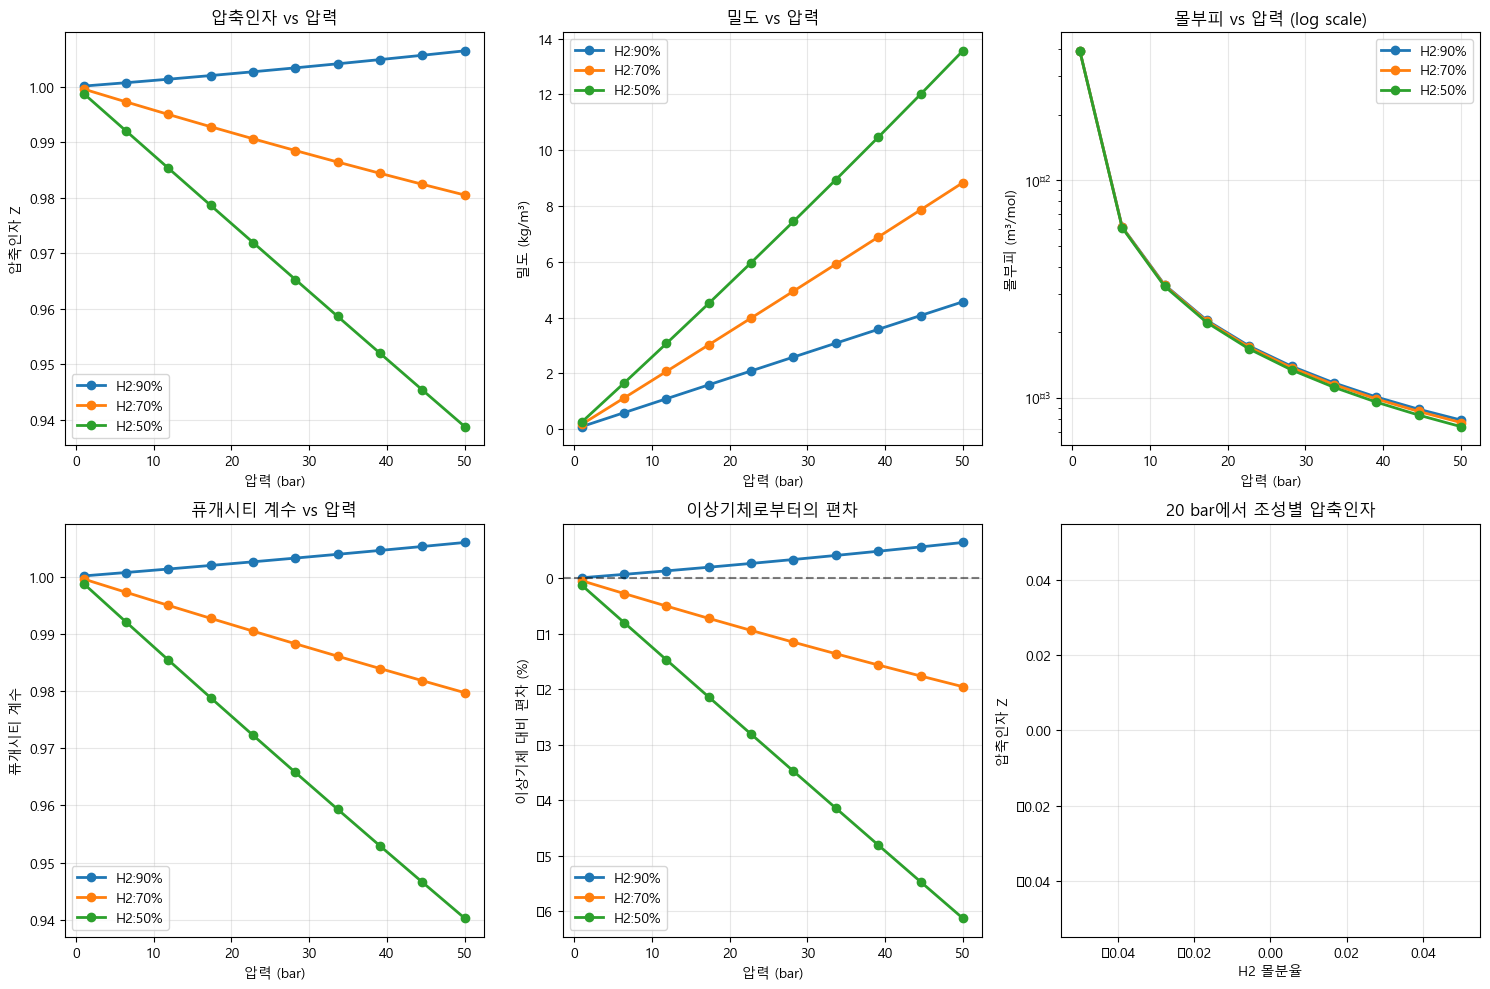


=== 계산 요약 ===
총 계산 포인트: 30
압력 범위: 1.0 - 50.0 bar
온도: 200.0°C


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import pandas as pd
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
class PengRobinson:
    """Peng-Robinson 상태방정식 클래스"""
    
    def __init__(self):
        # 가스 상수 (J/mol·K)
        self.R = 8.314
        
        # 성분별 임계 상수 및 이심인자
        self.components = {
            'H2': {
                'Tc': 33.145,    # K
                'Pc': 1.2964e6,  # Pa
                'omega': -0.215,  # 이심인자
                'Mw': 2.016      # g/mol
            },
            'H2O': {
                'Tc': 647.1,     # K
                'Pc': 2.2064e7,  # Pa
                'omega': 0.3449, # 이심인자
                'Mw': 18.015     # g/mol
            }
        }
        
        # 이성분 상호작용 계수 (kij)
        self.kij = {
            ('H2', 'H2O'): 0.0,  # 실제로는 0이 아니지만 단순화
            ('H2O', 'H2'): 0.0
        }
    
    def alpha_function(self, T, Tc, omega):
        """온도 의존 함수 α 계산"""
        Tr = T / Tc
        m = 0.37464 + 1.54226 * omega - 0.26992 * omega**2
        alpha = (1 + m * (1 - np.sqrt(Tr)))**2
        return alpha
    
    def pr_parameters(self, T, component):
        """성분별 PR 방정식 매개변수 계산"""
        comp_data = self.components[component]
        Tc = comp_data['Tc']
        Pc = comp_data['Pc']
        omega = comp_data['omega']
        
        # a와 b 계산
        a0 = 0.45724 * (self.R * Tc)**2 / Pc
        b = 0.07780 * self.R * Tc / Pc
        alpha = self.alpha_function(T, Tc, omega)
        a = a0 * alpha
        
        return a, b
    
    def mixing_rules(self, T, composition):
        """혼합 규칙 적용"""
        components = list(composition.keys())
        n = len(components)
        
        # 성분별 매개변수 계산
        a_params = {}
        b_params = {}
        
        for comp in components:
            a_params[comp], b_params[comp] = self.pr_parameters(T, comp)
        
        # 혼합 매개변수 계산
        a_mix = 0
        b_mix = 0
        
        for i, comp_i in enumerate(components):
            x_i = composition[comp_i]
            b_mix += x_i * b_params[comp_i]
            
            for j, comp_j in enumerate(components):
                x_j = composition[comp_j]
                
                # 이성분 상호작용 계수
                if comp_i == comp_j:
                    kij = 0
                else:
                    kij = self.kij.get((comp_i, comp_j), 0)
                
                a_ij = np.sqrt(a_params[comp_i] * a_params[comp_j]) * (1 - kij)
                a_mix += x_i * x_j * a_ij
        
        return a_mix, b_mix
    
    def compressibility_equation(self, Z, A, B):
        """압축인자 방정식 (3차 방정식)"""
        return Z**3 - (1 - B)*Z**2 + (A - 2*B - 3*B**2)*Z - (A*B - B**2 - B**3)
    
    def solve_for_Z(self, A, B):
        """압축인자 Z 계산"""
        # 3차 방정식의 근 찾기
        coeffs = [1, -(1-B), (A-2*B-3*B**2), -(A*B-B**2-B**3)]
        roots = np.roots(coeffs)
        
        # 실근만 선택
        real_roots = []
        for root in roots:
            if np.isreal(root) and root.real > 0:
                real_roots.append(root.real)
        
        if len(real_roots) == 1:
            return real_roots[0]
        elif len(real_roots) == 3:
            # 액체상과 기체상이 모두 존재하는 경우
            # 가장 작은 값은 액체상, 가장 큰 값은 기체상
            return min(real_roots), max(real_roots)
        else:
            return real_roots[0] if real_roots else 1.0
    
    def calculate_properties(self, T, P, composition, volume=None):
        """주어진 조건에서 열역학적 성질 계산"""
        
        # 혼합 매개변수 계산
        a_mix, b_mix = self.mixing_rules(T, composition)
        
        # 무차원 매개변수
        A = a_mix * P / (self.R * T)**2
        B = b_mix * P / (self.R * T)
        
        # 압축인자 계산
        Z_result = self.solve_for_Z(A, B)
        
        if isinstance(Z_result, tuple):
            Z_liquid, Z_vapor = Z_result
            results = {
                'liquid': self._calculate_phase_properties(T, P, Z_liquid, a_mix, b_mix, composition),
                'vapor': self._calculate_phase_properties(T, P, Z_vapor, a_mix, b_mix, composition)
            }
        else:
            Z = Z_result
            results = self._calculate_phase_properties(T, P, Z, a_mix, b_mix, composition)
        
        return results
    
    def _calculate_phase_properties(self, T, P, Z, a_mix, b_mix, composition):
        """각 상의 성질 계산"""
        
        # 몰 부피 (m³/mol)
        V = Z * self.R * T / P
        
        # 무차원 매개변수
        A = a_mix * P / (self.R * T)**2
        B = b_mix * P / (self.R * T)
        
        # 이탈인자 (departure factor)
        ln_phi = Z - 1 - np.log(Z - B) - A/(2*np.sqrt(2)*B) * np.log((Z + (1+np.sqrt(2))*B)/(Z + (1-np.sqrt(2))*B))
        
        # 퓨개시티 계수
        phi = np.exp(ln_phi)
        
        # 밀도 계산 (kg/m³)
        Mw_avg = sum(composition[comp] * self.components[comp]['Mw'] for comp in composition) / 1000  # kg/mol
        density = Mw_avg / V
        
        return {
            'compressibility_factor': Z,
            'molar_volume': V,  # m³/mol
            'density': density,  # kg/m³
            'fugacity_coefficient': phi,
            'A': A,
            'B': B
        }

def main():
    """메인 계산 함수"""
    
    # 계산 조건 설정
    T = 200 + 273.15  # 200°C를 K로 변환
    reactor_volume = 100e-6  # 100 mL를 m³로 변환
    
    # 다양한 조성과 압력에서 계산
    pressures = np.linspace(1e5, 50e5, 10)  # 1-50 bar
    compositions = [
        {'H2': 0.9, 'H2O': 0.1},  # H2 90%, H2O 10%
        {'H2': 0.7, 'H2O': 0.3},  # H2 70%, H2O 30%
        {'H2': 0.5, 'H2O': 0.5},  # H2 50%, H2O 50%
    ]
    
    pr = PengRobinson()
    
    print(f"=== Peng-Robinson 상태방정식 계산 결과 ===")
    print(f"온도: {T-273.15:.1f}°C ({T:.1f} K)")
    print(f"반응기 부피: {reactor_volume*1e6:.1f} mL")
    print("="*60)
    
    results_data = []
    
    for comp_idx, composition in enumerate(compositions):
        print(f"\n조성 {comp_idx+1}: H2 {composition['H2']*100:.0f}%, H2O {composition['H2O']*100:.0f}%")
        print("-"*60)
        print(f"{'압력(bar)':>10} {'Z':>8} {'밀도(kg/m³)':>12} {'몰부피(m³/mol)':>15} {'퓨개시티계수':>12}")
        
        for P in pressures:
            try:
                result = pr.calculate_properties(T, P, composition)
                
                if isinstance(result, dict) and 'liquid' in result:
                    # 두 상이 모두 존재하는 경우
                    phase = 'vapor'  # 고온에서는 주로 기체상
                    props = result[phase]
                else:
                    props = result
                
                P_bar = P / 1e5
                Z = props['compressibility_factor']
                density = props['density']
                V_molar = props['molar_volume']
                phi = props['fugacity_coefficient']
                
                print(f"{P_bar:10.1f} {Z:8.4f} {density:12.2f} {V_molar:15.6e} {phi:12.4f}")
                
                results_data.append({
                    'Composition': f"H2:{composition['H2']*100:.0f}%",
                    'Pressure_bar': P_bar,
                    'Z_factor': Z,
                    'Density_kg_m3': density,
                    'Molar_volume_m3_mol': V_molar,
                    'Fugacity_coefficient': phi
                })
                
            except Exception as e:
                print(f"{P/1e5:10.1f} 계산 오류: {str(e)}")
    
    # 결과를 DataFrame으로 저장
    df_results = pd.DataFrame(results_data)
    
    # 그래프 생성
    plt.figure(figsize=(15, 10))
    
    # 1. 압축인자 vs 압력
    plt.subplot(2, 3, 1)
    for comp_idx, composition in enumerate(compositions):
        comp_name = f"H2:{composition['H2']*100:.0f}%"
        data = df_results[df_results['Composition'] == comp_name]
        plt.plot(data['Pressure_bar'], data['Z_factor'], 'o-', 
                label=comp_name, linewidth=2, markersize=6)
    plt.xlabel('압력 (bar)')
    plt.ylabel('압축인자 Z')
    plt.title('압축인자 vs 압력')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. 밀도 vs 압력
    plt.subplot(2, 3, 2)
    for comp_idx, composition in enumerate(compositions):
        comp_name = f"H2:{composition['H2']*100:.0f}%"
        data = df_results[df_results['Composition'] == comp_name]
        plt.plot(data['Pressure_bar'], data['Density_kg_m3'], 'o-', 
                label=comp_name, linewidth=2, markersize=6)
    plt.xlabel('압력 (bar)')
    plt.ylabel('밀도 (kg/m³)')
    plt.title('밀도 vs 압력')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. 몰부피 vs 압력
    plt.subplot(2, 3, 3)
    for comp_idx, composition in enumerate(compositions):
        comp_name = f"H2:{composition['H2']*100:.0f}%"
        data = df_results[df_results['Composition'] == comp_name]
        plt.semilogy(data['Pressure_bar'], data['Molar_volume_m3_mol'], 'o-', 
                    label=comp_name, linewidth=2, markersize=6)
    plt.xlabel('압력 (bar)')
    plt.ylabel('몰부피 (m³/mol)')
    plt.title('몰부피 vs 압력 (log scale)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. 퓨개시티 계수 vs 압력
    plt.subplot(2, 3, 4)
    for comp_idx, composition in enumerate(compositions):
        comp_name = f"H2:{composition['H2']*100:.0f}%"
        data = df_results[df_results['Composition'] == comp_name]
        plt.plot(data['Pressure_bar'], data['Fugacity_coefficient'], 'o-', 
                label=comp_name, linewidth=2, markersize=6)
    plt.xlabel('압력 (bar)')
    plt.ylabel('퓨개시티 계수')
    plt.title('퓨개시티 계수 vs 압력')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 5. 이상기체 대비 편차
    plt.subplot(2, 3, 5)
    for comp_idx, composition in enumerate(compositions):
        comp_name = f"H2:{composition['H2']*100:.0f}%"
        data = df_results[df_results['Composition'] == comp_name]
        deviation = (data['Z_factor'] - 1) * 100
        plt.plot(data['Pressure_bar'], deviation, 'o-', 
                label=comp_name, linewidth=2, markersize=6)
    plt.xlabel('압력 (bar)')
    plt.ylabel('이상기체 대비 편차 (%)')
    plt.title('이상기체로부터의 편차')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.5)
    
    # 6. 조성별 압축인자 비교 (특정 압력에서)
    plt.subplot(2, 3, 6)
    P_fixed = 20  # 20 bar에서 비교
    h2_fractions = []
    z_factors = []
    
    for composition in compositions:
        data = df_results[(df_results['Composition'] == f"H2:{composition['H2']*100:.0f}%") & 
                         (abs(df_results['Pressure_bar'] - P_fixed) < 1)]
        if not data.empty:
            h2_fractions.append(composition['H2'])
            z_factors.append(data['Z_factor'].iloc[0])
    
    plt.plot(h2_fractions, z_factors, 'ro-', linewidth=2, markersize=8)
    plt.xlabel('H2 몰분율')
    plt.ylabel('압축인자 Z')
    plt.title(f'{P_fixed} bar에서 조성별 압축인자')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 요약 정보 출력
    print(f"\n=== 계산 요약 ===")
    print(f"총 계산 포인트: {len(df_results)}")
    print(f"압력 범위: {pressures[0]/1e5:.1f} - {pressures[-1]/1e5:.1f} bar")
    print(f"온도: {T-273.15:.1f}°C")
    
    return df_results

if __name__ == "__main__":
    results = main()

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import pandas as pd

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'

class PengRobinson:
    """Peng-Robinson 상태방정식 클래스"""
    
    def __init__(self):
        # 가스 상수 (J/mol·K)
        self.R = 8.314
        
        # 성분별 임계 상수 및 이심인자
        self.components = {
            'H2': {
                'Tc': 33.145,    # K
                'Pc': 1.2964e6,  # Pa
                'omega': -0.215,  # 이심인자
                'Mw': 2.016      # g/mol
            },
            'H2O': {
                'Tc': 647.1,     # K
                'Pc': 2.2064e7,  # Pa
                'omega': 0.3449, # 이심인자
                'Mw': 18.015     # g/mol
            }
        }
        
        # 이성분 상호작용 계수 (kij)
        self.kij = {
            ('H2', 'H2O'): 0.0,
            ('H2O', 'H2'): 0.0
        }
    
    def alpha_function(self, T, Tc, omega):
        """온도 의존 함수 α 계산"""
        Tr = T / Tc
        m = 0.37464 + 1.54226 * omega - 0.26992 * omega**2
        alpha = (1 + m * (1 - np.sqrt(Tr)))**2
        return alpha
    
    def pr_parameters(self, T, component):
        """성분별 PR 방정식 매개변수 계산"""
        comp_data = self.components[component]
        Tc = comp_data['Tc']
        Pc = comp_data['Pc']
        omega = comp_data['omega']
        
        # a와 b 계산
        a0 = 0.45724 * (self.R * Tc)**2 / Pc
        b = 0.07780 * self.R * Tc / Pc
        alpha = self.alpha_function(T, Tc, omega)
        a = a0 * alpha
        
        return a, b
    
    def mixing_rules(self, T, composition):
        """혼합 규칙 적용"""
        components = list(composition.keys())
        
        # 성분별 매개변수 계산
        a_params = {}
        b_params = {}
        
        for comp in components:
            a_params[comp], b_params[comp] = self.pr_parameters(T, comp)
        
        # 혼합 매개변수 계산
        a_mix = 0
        b_mix = 0
        
        for i, comp_i in enumerate(components):
            x_i = composition[comp_i]
            b_mix += x_i * b_params[comp_i]
            
            for j, comp_j in enumerate(components):
                x_j = composition[comp_j]
                
                # 이성분 상호작용 계수
                if comp_i == comp_j:
                    kij = 0
                else:
                    kij = self.kij.get((comp_i, comp_j), 0)
                
                a_ij = np.sqrt(a_params[comp_i] * a_params[comp_j]) * (1 - kij)
                a_mix += x_i * x_j * a_ij
        
        return a_mix, b_mix
    
    def pr_equation_for_pressure(self, P, T, V, composition):
        """주어진 T, V, 조성에서 압력 방정식의 잔차"""
        
        # 혼합 매개변수 계산
        a_mix, b_mix = self.mixing_rules(T, composition)
        
        # PR 방정식: P = RT/(V-b) - a/(V² + 2bV - b²)
        P_calculated = (self.R * T / (V - b_mix)) - (a_mix / (V**2 + 2*b_mix*V - b_mix**2))
        
        return P_calculated - P
    
    def calculate_pressure_from_volume(self, T, V_total, n_total, composition):
        """주어진 온도, 부피, 총 몰수에서 압력 계산"""
        
        # 몰부피 계산 (m³/mol)
        V_molar = V_total / n_total
        
        # 혼합 매개변수 계산
        a_mix, b_mix = self.mixing_rules(T, composition)
        
        # PR 방정식으로 압력 직접 계산
        # P = RT/(V-b) - a/(V² + 2bV - b²)
        P = (self.R * T / (V_molar - b_mix)) - (a_mix / (V_molar**2 + 2*b_mix*V_molar - b_mix**2))
        
        # 압축인자도 계산
        Z = P * V_molar / (self.R * T)
        
        return P, Z, V_molar

def calculate_reactor_conditions():
    """반응기 조건에서 압력 계산"""
    
    # 주어진 조건
    T = 200 + 273.15  # 200°C를 K로 변환
    V_reactor = 145e-6  # 145 mL를 m³로 변환
    V_water = 23e-6     # 23 mL 물을 m³로 변환
    n_H2 = 0.202        # 202 mmol H2를 mol로 변환
    
    # 물의 몰수 계산 (액체 물의 밀도를 1000 kg/m³로 가정)
    rho_water = 1000  # kg/m³
    Mw_H2O = 18.015e-3  # kg/mol
    mass_water = rho_water * V_water  # kg
    n_H2O = mass_water / Mw_H2O  # mol
    
    # 기체상 부피 (전체 반응기 부피 - 액체 물 부피)
    V_gas = V_reactor - V_water
    
    # 총 기체 몰수 (H2 + 증기 H2O)
    # 200°C에서 물의 증기압 고려 (약 15.5 bar)
    P_sat_H2O = 15.5e5  # Pa (200°C에서 물의 포화증기압)
    
    print(f"=== 반응기 조건 분석 ===")
    print(f"온도: {T-273.15:.1f}°C ({T:.1f} K)")
    print(f"총 반응기 부피: {V_reactor*1e6:.1f} mL")
    print(f"액체 물 부피: {V_water*1e6:.1f} mL")
    print(f"기체상 부피: {V_gas*1e6:.1f} mL")
    print(f"H2 몰수: {n_H2*1000:.1f} mmol")
    print(f"액체 H2O 몰수: {n_H2O*1000:.1f} mmol")
    print(f"200°C에서 H2O 포화증기압: {P_sat_H2O/1e5:.1f} bar")
    print("="*50)
    
    pr = PengRobinson()
    
    # 여러 시나리오 계산
    scenarios = []
    
    # 시나리오 1: 물이 모두 액체 상태 (증기압 무시)
    composition_1 = {'H2': 1.0, 'H2O': 0.0}  # 순수 H2
    n_total_1 = n_H2
    
    P1, Z1, V_molar_1 = pr.calculate_pressure_from_volume(T, V_gas, n_total_1, composition_1)
    scenarios.append({
        'scenario': '물이 모두 액체 (증기 무시)',
        'composition': composition_1,
        'n_total': n_total_1,
        'pressure_bar': P1/1e5,
        'Z': Z1,
        'V_molar': V_molar_1
    })
    
    # 시나리오 2: 포화 수증기 존재
    # 포화조건에서 수증기 몰수 계산
    n_H2O_vapor_sat = P_sat_H2O * V_gas / (self.R * T)  # 이상기체 근사
    composition_2 = {
        'H2': n_H2 / (n_H2 + n_H2O_vapor_sat),
        'H2O': n_H2O_vapor_sat / (n_H2 + n_H2O_vapor_sat)
    }
    n_total_2 = n_H2 + n_H2O_vapor_sat
    
    try:
        P2, Z2, V_molar_2 = pr.calculate_pressure_from_volume(T, V_gas, n_total_2, composition_2)
        scenarios.append({
            'scenario': '포화 수증기 존재',
            'composition': composition_2,
            'n_total': n_total_2,
            'pressure_bar': P2/1e5,
            'Z': Z2,
            'V_molar': V_molar_2,
            'n_H2O_vapor_mmol': n_H2O_vapor_sat*1000
        })
    except:
        scenarios.append({
            'scenario': '포화 수증기 존재',
            'composition': composition_2,
            'error': '계산 불가능 (부피 제약)'
        })
    
    # 시나리오 3: 모든 물이 증기화 (극한 경우)
    composition_3 = {
        'H2': n_H2 / (n_H2 + n_H2O),
        'H2O': n_H2O / (n_H2 + n_H2O)
    }
    n_total_3 = n_H2 + n_H2O
    
    try:
        P3, Z3, V_molar_3 = pr.calculate_pressure_from_volume(T, V_gas, n_total_3, composition_3)
        scenarios.append({
            'scenario': '모든 물이 증기화',
            'composition': composition_3,
            'n_total': n_total_3,
            'pressure_bar': P3/1e5,
            'Z': Z3,
            'V_molar': V_molar_3
        })
    except:
        scenarios.append({
            'scenario': '모든 물이 증기화',
            'composition': composition_3,
            'error': '계산 불가능 (부피 제약)'
        })
    
    # 결과 출력
    print(f"\n{'시나리오':<15} {'압력(bar)':<12} {'압축인자':<10} {'H2 몰분율':<12} {'H2O 몰분율':<12}")
    print("-"*70)
    
    for scenario in scenarios:
        if 'error' in scenario:
            print(f"{scenario['scenario']:<15} {scenario['error']}")
        else:
            comp = scenario['composition']
            print(f"{scenario['scenario']:<15} {scenario['pressure_bar']:<12.2f} {scenario['Z']:<10.4f} "
                  f"{comp['H2']:<12.4f} {comp['H2O']:<12.4f}")
    
    # 가장 현실적인 시나리오 (시나리오 2) 상세 분석
    print(f"\n=== 가장 현실적인 경우 (포화 수증기 존재) ===")
    if len(scenarios) > 1 and 'error' not in scenarios[1]:
        scenario = scenarios[1]
        print(f"총 압력: {scenario['pressure_bar']:.2f} bar")
        print(f"H2 분압: {scenario['pressure_bar'] * scenario['composition']['H2']:.2f} bar")
        print(f"H2O 분압: {scenario['pressure_bar'] * scenario['composition']['H2O']:.2f} bar")
        print(f"압축인자: {scenario['Z']:.4f}")
        print(f"기체상 H2O: {scenario.get('n_H2O_vapor_mmol', 0):.1f} mmol")
        print(f"액체상 H2O: {(n_H2O - scenario.get('n_H2O_vapor_mmol', 0)/1000)*1000:.1f} mmol")
    
    # 온도별 압력 변화 계산
    temperatures = np.linspace(150, 250, 11) + 273.15  # 150-250°C
    pressures_temp = []
    
    composition_base = scenarios[0]['composition']  # 순수 H2 경우
    
    for T_var in temperatures:
        try:
            P_temp, _, _ = pr.calculate_pressure_from_volume(T_var, V_gas, n_H2, composition_base)
            pressures_temp.append(P_temp/1e5)
        except:
            pressures_temp.append(np.nan)
    
    # 그래프 그리기
    plt.figure(figsize=(12, 8))
    
    # 온도에 따른 압력 변화
    plt.subplot(2, 2, 1)
    plt.plot(temperatures-273.15, pressures_temp, 'bo-', linewidth=2, markersize=6)
    plt.axvline(x=200, color='r', linestyle='--', alpha=0.7, label='현재 온도')
    plt.xlabel('온도 (°C)')
    plt.ylabel('압력 (bar)')
    plt.title('온도에 따른 압력 변화 (순수 H2)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 시나리오별 압력 비교
    plt.subplot(2, 2, 2)
    scenario_names = [s['scenario'] for s in scenarios if 'error' not in s]
    scenario_pressures = [s['pressure_bar'] for s in scenarios if 'error' not in s]
    
    bars = plt.bar(range(len(scenario_names)), scenario_pressures, 
                   color=['skyblue', 'lightgreen', 'salmon'][:len(scenario_names)])
    plt.xlabel('시나리오')
    plt.ylabel('압력 (bar)')
    plt.title('시나리오별 압력 비교')
    plt.xticks(range(len(scenario_names)), [name[:10] for name in scenario_names], rotation=45)
    
    # 막대 위에 값 표시
    for bar, pressure in zip(bars, scenario_pressures):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                f'{pressure:.1f}', ha='center', va='bottom')
    
    plt.tight_layout()
    
    # H2 몰수에 따른 압력 변화
    plt.subplot(2, 2, 3)
    n_H2_range = np.linspace(0.1, 0.4, 20)  # 100-400 mmol
    pressures_n = []
    
    for n in n_H2_range:
        try:
            P_n, _, _ = pr.calculate_pressure_from_volume(T, V_gas, n, composition_base)
            pressures_n.append(P_n/1e5)
        except:
            pressures_n.append(np.nan)
    
    plt.plot(n_H2_range*1000, pressures_n, 'go-', linewidth=2, markersize=4)
    plt.axvline(x=202, color='r', linestyle='--', alpha=0.7, label='현재 H2량')
    plt.xlabel('H2 몰수 (mmol)')
    plt.ylabel('압력 (bar)')
    plt.title('H2 몰수에 따른 압력 변화')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # 압축인자 비교
    plt.subplot(2, 2, 4)
    scenario_Z = [s['Z'] for s in scenarios if 'error' not in s]
    
    bars = plt.bar(range(len(scenario_names)), scenario_Z, 
                   color=['skyblue', 'lightgreen', 'salmon'][:len(scenario_names)])
    plt.xlabel('시나리오')
    plt.ylabel('압축인자 Z')
    plt.title('시나리오별 압축인자')
    plt.xticks(range(len(scenario_names)), [name[:10] for name in scenario_names], rotation=45)
    plt.axhline(y=1, color='k', linestyle='--', alpha=0.5, label='이상기체')
    
    # 막대 위에 값 표시
    for bar, z_val in zip(bars, scenario_Z):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{z_val:.3f}', ha='center', va='bottom')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return scenarios

if __name__ == "__main__":
    results = calculate_reactor_conditions()

=== 반응기 조건 분석 ===
온도: 200.0°C (473.1 K)
총 반응기 부피: 145.0 mL
액체 물 부피: 23.0 mL
기체상 부피: 122.0 mL
H2 몰수: 202.0 mmol
액체 H2O 몰수: 1276.7 mmol
200°C에서 H2O 포화증기압: 15.5 bar


NameError: name 'self' is not defined

모든 계산 방법 실행 및 비교
=== thermo 라이브러리 사용 (방법 1: Chemical 객체) ===
온도: 200.0°C
기체상 부피: 122.0 mL
H2 몰수: 202.0 mmol
----------------------------------------
H2 임계온도: 33.15 K
H2 임계압력: 12.96 bar
H2 이심인자: -0.219
몰부피: 6.039604e-04 m³/mol
이상기체 압력: 65.13 bar
[473.15, array([-6.44815692e+08]), 1.6537538424740283e-05, 3.3075076849480566e-05, -2.734901771497613e-10, 0.023341299183940026, 'coordinates of failure']
[473.15, array([-3.19151201e+08]), 1.6537538424740283e-05, 3.3075076849480566e-05, -2.734901771497613e-10, 0.023341299183940026, 'coordinates of failure']
[473.15, array([-6.44815692e+08]), 1.6537538424740283e-05, 3.3075076849480566e-05, -2.734901771497613e-10, 0.023341299183940026, 'coordinates of failure']
[473.15, array([-3.19151201e+08]), 1.6537538424740283e-05, 3.3075076849480566e-05, -2.734901771497613e-10, 0.023341299183940026, 'coordinates of failure']
[473.15, array([-1.56318956e+08]), 1.6537538424740283e-05, 3.3075076849480566e-05, -2.734901771497613e-10, 0.023341299183940026, 'coord

C:\Users\USER\AppData\Local\Temp\ipykernel_38664\1970216903.py:62: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  P_solution = fsolve(find_pressure, P_initial)[0]


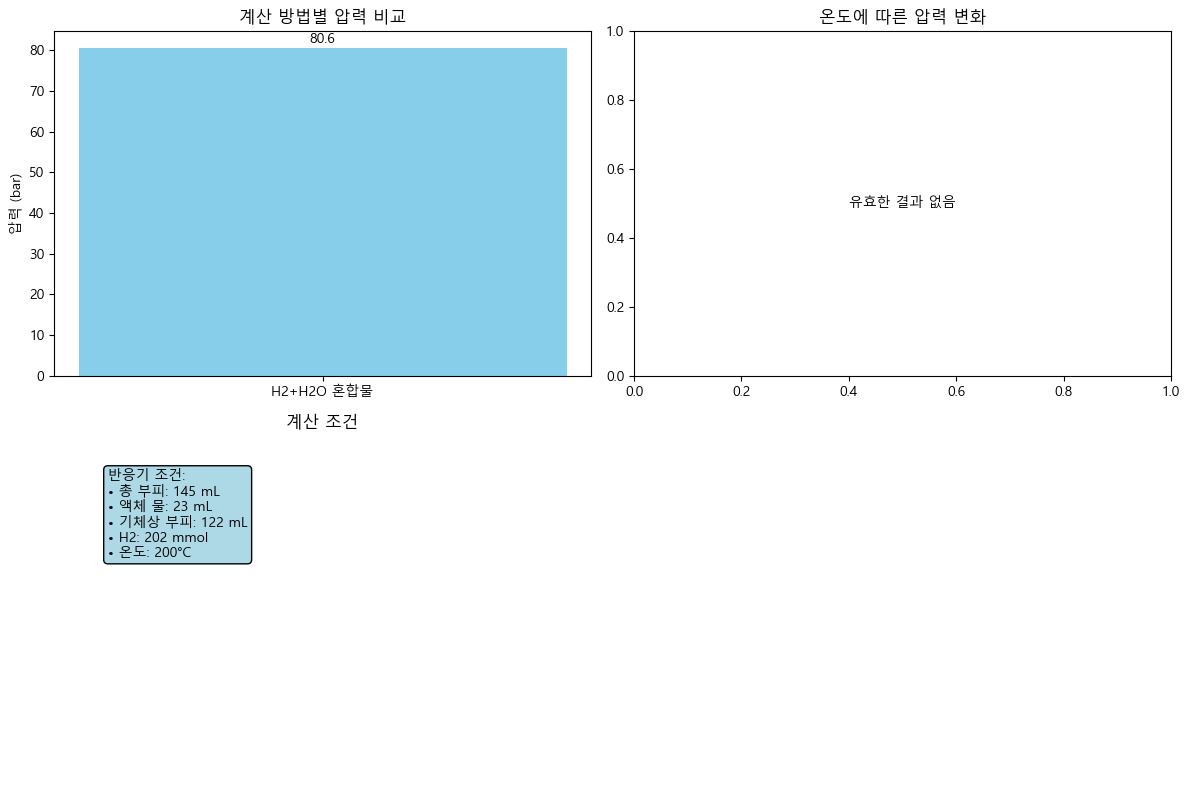

In [18]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
# thermo 라이브러리 import
try:
    from thermo import Chemical, Mixture
    from thermo.eos import PR
    THERMO_AVAILABLE = True
except ImportError as e:
    print(f"thermo 라이브러리를 찾을 수 없습니다: {e}")
    print("설치: pip install thermo")
    THERMO_AVAILABLE = False

def calculate_with_thermo_simple():
    """thermo 라이브러리의 간단한 사용법"""
    
    if not THERMO_AVAILABLE:
        return
    
    print("=== thermo 라이브러리 사용 (방법 1: Chemical 객체) ===")
    
    # 주어진 조건
    T = 200 + 273.15  # 200°C를 K로 변환
    V_reactor = 145e-6  # 145 mL를 m³로 변환
    V_water = 23e-6     # 23 mL 물을 m³로 변환
    n_H2 = 0.202        # 202 mmol H2를 mol로 변환
    V_gas = V_reactor - V_water  # 기체상 부피
    
    print(f"온도: {T-273.15:.1f}°C")
    print(f"기체상 부피: {V_gas*1e6:.1f} mL")
    print(f"H2 몰수: {n_H2*1000:.1f} mmol")
    print("-" * 40)
    
    try:
        # H2 Chemical 객체 생성
        h2 = Chemical('hydrogen')
        print(f"H2 임계온도: {h2.Tc:.2f} K")
        print(f"H2 임계압력: {h2.Pc/1e5:.2f} bar")
        print(f"H2 이심인자: {h2.omega:.3f}")
        
        # 몰부피 계산
        V_molar = V_gas / n_H2  # m³/mol
        print(f"몰부피: {V_molar:.6e} m³/mol")
        
        # Peng-Robinson EOS로 압력 계산
        from scipy.optimize import fsolve
        
        def find_pressure(P):
            """주어진 압력에서 PR EOS로 계산한 몰부피와 실제 몰부피의 차이"""
            try:
                pr_eos = PR(T=T, P=P, Tc=h2.Tc, Pc=h2.Pc, omega=h2.omega)
                V_calculated = pr_eos.V_g  # 기체상 몰부피
                return V_calculated - V_molar
            except:
                return 1e10  # 계산 불가능한 경우 큰 값 반환
        
        # 초기 추정값 (이상기체 압력)
        P_initial = n_H2 * 8.314 * T / V_gas
        print(f"이상기체 압력: {P_initial/1e5:.2f} bar")
        
        # 압력 찾기
        P_solution = fsolve(find_pressure, P_initial)[0]
        
        # 최종 결과 계산
        pr_final = PR(T=T, P=P_solution, Tc=h2.Tc, Pc=h2.Pc, omega=h2.omega)
        Z = pr_final.Z_g
        
        print(f"\n*** 결과 ***")
        print(f"실제 압력: {P_solution/1e5:.2f} bar")
        print(f"압축인자: {Z:.4f}")
        print(f"계산된 몰부피: {pr_final.V_g:.6e} m³/mol")
        print(f"편차: {((P_solution-P_initial)/P_initial)*100:.1f}%")
        
        return P_solution, Z
        
    except Exception as e:
        print(f"오류 발생: {e}")
        return None, None

def calculate_with_thermo_mixture():
    """thermo 라이브러리의 혼합물 계산"""
    
    if not THERMO_AVAILABLE:
        return None, None, None
    
    print(f"\n=== thermo 라이브러리 사용 (방법 2: 혼합물) ===")
    
    # 조건 설정
    T = 200 + 273.15
    V_reactor = 145e-6
    V_water = 23e-6
    n_H2 = 0.202
    V_gas = V_reactor - V_water
    
    try:
        # Chemical 객체로 직접 계산
        h2 = Chemical('hydrogen')
        h2o = Chemical('water')
        
        print("Chemical 객체 생성 성공")
        
        # 물의 포화증기압 계산
        try:
            # 200°C에서 물의 포화증기압 계산
            h2o_at_temp = Chemical('water', T=T, P=101325)
            if hasattr(h2o_at_temp, 'Psat') and callable(h2o_at_temp.Psat):
                water_sat_P = h2o_at_temp.Psat()
            elif hasattr(h2o, 'Psat') and callable(h2o.Psat):
                water_sat_P = h2o.Psat(T)
            else:
                # 수동 계산 (Antoine 방정식 근사)
                water_sat_P = 15.5e5  # 200°C에서 약 15.5 bar
            
        except Exception as e:
            print(f"포화증기압 계산 오류: {e}, 근사값 사용")
            water_sat_P = 15.5e5
        
        print(f"200°C에서 물의 포화증기압: {water_sat_P/1e5:.1f} bar")
        
        # 포화 수증기 몰수 (이상기체 근사)
        n_H2O_vapor = water_sat_P * V_gas / (8.314 * T)
        n_total = n_H2 + n_H2O_vapor
        
        # 몰분율
        x_H2 = n_H2 / n_total
        x_H2O = n_H2O_vapor / n_total
        
        print(f"H2O 증기 몰수: {n_H2O_vapor*1000:.1f} mmol")
        print(f"H2 몰분율: {x_H2:.3f}")
        print(f"H2O 몰분율: {x_H2O:.3f}")
        
        # 혼합물 압력 (이상기체 근사로 시작)
        P_mix_ideal = n_total * 8.314 * T / V_gas
        
        print(f"\n*** 혼합물 결과 ***")
        print(f"총 압력 (이상기체): {P_mix_ideal/1e5:.2f} bar")
        print(f"H2 부분압: {x_H2 * P_mix_ideal/1e5:.2f} bar")
        print(f"H2O 부분압: {x_H2O * P_mix_ideal/1e5:.2f} bar")
        
        return P_mix_ideal, x_H2, x_H2O
        
    except Exception as e:
        print(f"혼합물 계산 오류: {e}")
        return None, None, None

def calculate_with_thermo_flash():
    """thermo 라이브러리의 Mixture 객체 시도"""
    
    if not THERMO_AVAILABLE:
        return False
    
    print(f"\n=== thermo 라이브러리 사용 (방법 3: Mixture 객체) ===")
    
    try:
        # Mixture 객체 직접 생성 시도
        zs = [0.9, 0.1]  # H2 90%, H2O 10% 몰분율
        T = 200 + 273.15
        
        mixture = Mixture(['hydrogen', 'water'], zs=zs, T=T, P=101325)
        
        print(f"혼합물 생성 성공")
        print(f"성분: {mixture.IDs}")
        print(f"몰분율: {mixture.zs}")
        
        # 간단한 물성 계산
        if hasattr(mixture, 'rho') and mixture.rho is not None:
            print(f"밀도: {mixture.rho:.3f} kg/m³")
        if hasattr(mixture, 'Z') and mixture.Z is not None:
            print(f"압축인자: {mixture.Z:.4f}")
        
        return True
        
    except Exception as e:
        print(f"Mixture 객체 생성 오류: {e}")
        return False

def compare_all_methods():
    """모든 방법의 결과 비교"""
    
    print("="*60)
    print("모든 계산 방법 실행 및 비교")
    print("="*60)
    
    # 각 방법 실행
    result1 = calculate_with_thermo_simple()
    result2 = calculate_with_thermo_mixture()
    result3 = calculate_with_thermo_flash()
    
    # 결과 요약
    print(f"\n{'='*60}")
    print("결과 요약")
    print(f"{'='*60}")
    
    # None 체크 개선
    if result1 is not None and result1[0] is not None:
        print(f"방법 1 (순수 H2): {result1[0]/1e5:.2f} bar, Z = {result1[1]:.4f}")
    else:
        print("방법 1 (순수 H2): 계산 실패")
    
    if result2 is not None and result2[0] is not None:
        print(f"방법 2 (혼합물): {result2[0]/1e5:.2f} bar")
        print(f"  - H2 부분압: {result2[1] * result2[0]/1e5:.2f} bar")
        print(f"  - H2O 부분압: {result2[2] * result2[0]/1e5:.2f} bar")
    else:
        print("방법 2 (혼합물): 계산 실패")
    
    if result3:
        print("방법 3 (Mixture): 계산 성공")
    else:
        print("방법 3 (Mixture): 계산 실패")
    
    # 시각화 - 유효한 결과가 있을 때만
    valid_result1 = result1 is not None and result1[0] is not None
    valid_result2 = result2 is not None and result2[0] is not None
    
    if valid_result1 or valid_result2:
        create_visualization(result1, result2)

def create_visualization(result1, result2):
    """결과 시각화"""
    
    plt.figure(figsize=(12, 8))
    
    # 압력 비교
    plt.subplot(2, 2, 1)
    methods = []
    pressures = []
    
    if result1 is not None and result1[0] is not None:
        methods.append('순수 H2')
        pressures.append(result1[0]/1e5)
    
    if result2 is not None and result2[0] is not None:
        methods.append('H2+H2O 혼합물')
        pressures.append(result2[0]/1e5)
    
    if methods:  # 표시할 데이터가 있을 때만
        bars = plt.bar(methods, pressures, color=['skyblue', 'lightgreen'][:len(methods)])
        plt.ylabel('압력 (bar)')
        plt.title('계산 방법별 압력 비교')
        
        # 막대 위에 값 표시
        for bar, pressure in zip(bars, pressures):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                    f'{pressure:.1f}', ha='center', va='bottom')
    else:
        plt.text(0.5, 0.5, '계산 결과 없음', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('계산 방법별 압력 비교')
    
    # 온도에 따른 압력 변화 (순수 H2) - result1이 유효할 때만
    plt.subplot(2, 2, 2)
    if result1 is not None and result1[0] is not None:
        temperatures = np.linspace(150, 250, 11) + 273.15
        pressures_temp = []
        
        V_reactor = 145e-6
        V_water = 23e-6
        n_H2 = 0.202
        V_gas = V_reactor - V_water
        
        try:
            h2 = Chemical('hydrogen')
            
            for T_var in temperatures:
                try:
                    from scipy.optimize import fsolve
                    V_molar = V_gas / n_H2
                    
                    def find_P(P):
                        try:
                            pr = PR(T=T_var, P=P, Tc=h2.Tc, Pc=h2.Pc, omega=h2.omega)
                            return pr.V_g - V_molar
                        except:
                            return 1e10
                    
                    P_initial = n_H2 * 8.314 * T_var / V_gas
                    P_sol = fsolve(find_P, P_initial)[0]
                    pressures_temp.append(P_sol/1e5)
                except:
                    pressures_temp.append(np.nan)
            
            plt.plot(temperatures-273.15, pressures_temp, 'bo-', linewidth=2)
            plt.axvline(x=200, color='r', linestyle='--', alpha=0.7, label='현재 온도')
            plt.xlabel('온도 (°C)')
            plt.ylabel('압력 (bar)')
            plt.title('온도에 따른 압력 변화')
            plt.legend()
            plt.grid(True, alpha=0.3)
        except Exception as e:
            plt.text(0.5, 0.5, f'계산 오류:\n{str(e)}', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('온도에 따른 압력 변화')
    else:
        plt.text(0.5, 0.5, '유효한 결과 없음', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('온도에 따른 압력 변화')
    
    # 추가 정보 표시
    plt.subplot(2, 2, 3)
    info_text = "반응기 조건:\n"
    info_text += "• 총 부피: 145 mL\n"
    info_text += "• 액체 물: 23 mL\n"
    info_text += "• 기체상 부피: 122 mL\n"
    info_text += "• H2: 202 mmol\n"
    info_text += "• 온도: 200°C"
    
    plt.text(0.1, 0.9, info_text, transform=plt.gca().transAxes, 
             verticalalignment='top', fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    plt.axis('off')
    plt.title('계산 조건')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    if THERMO_AVAILABLE:
        compare_all_methods()
    else:
        print("thermo 라이브러리를 먼저 설치해주세요:")
        print("pip install thermo")

In [16]:
from thermo.eos import PR

In [ ]:
from thermo.